In [1]:
import pyodbc                # Needed to connect to ODBC data sources
import base64                # Needed to de-fuzzy my encrypted password
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib.ticker import MultipleLocator
import pandas as pd

pw_file = open(r'D:\webapps\_server\pyodbc\cmq.txt', 'r')
pw = base64.b64decode(pw_file.read()).decode('utf-8')
userid = 'yomama'
pw_file.close()

cnxn_string = 'DSN=yo_db;UID=' + userid + ';PWD=' + pw

cnxn = pyodbc.connect(cnxn_string)
cursor = cnxn.cursor()

# Get the necessary input from the user
repl_part = input("Enter replaced part#(s) separated by comma: ")
year = input("Enter model year(s) separated by comma: ")
factory = input("Enter factory code(s) separated by comma: ")
model = input("Enter model name(s) separated by comma: ")
dest_code = input("Enter destination code(s), separated by comma: ")

# Make a list for each parameter input
repl_parts = repl_part.split(',')
years      = year.split(',')
factories  = factory.split(',')
models     = model.split(',')
dest_codes = dest_code.split(',')

# Now get the number of items in each list so that we can properly use th .join() function above
R = len(repl_parts)  # The number of replaced part #s the user entered
Y = len(years)       # The number of years the user entered
F = len(factories)   # The number of factories the user entered
M = len(models)      # The number of models the user entered
D = len(dest_codes)  # The number of destination codes the user entered

# In this SQL, there are 5 parameters that we want to get input from the user using IN(%s)
sql = """
WITH REPL AS
(SELECT
REPL_PART_SK,
CLM_SK

FROM CMQ.V_FACT_CLM_REPL_PART REPL
INNER JOIN CMQ.V_DIM_PART PART
ON REPL.REPL_PART_SK = PART.PART_SK

WHERE
PART.SHRT_PART_NO IN(%s)
),

VINS AS
(SELECT DISTINCT
PROD.VIN_SK,
PROD.VIN_NO

FROM
CMQ.V_FACT_VHCL_PRDN_SLS PROD

INNER JOIN CMQ.V_DIM_MTO MTO
ON PROD.MTO_SK = MTO.MTO_SK

WHERE
MTO.MDL_YR IN(%s)
AND MTO.FCTRY_CD IN(%s)
AND MTO.MDL_NM IN(%s)
AND DEST_CD IN(%s)
)

SELECT
REC_DT,
COUNT(*) AS QTY

FROM(
SELECT
REPL.CLM_SK,
VINS.VIN_NO,
REC_CAL.CAL_DT AS REC_DT,
DPART.SHRT_PART_NO AS REPL_PART

FROM
CMQ.V_FACT_CLM_TRX CLAIMS
INNER JOIN REPL
ON CLAIMS.CLM_SK = REPL.CLM_SK

INNER JOIN VINS
ON CLAIMS.VIN_SK = VINS.VIN_SK

INNER JOIN CMQ.V_DIM_DATE REC_CAL
ON CLAIMS.CMQ_RCV_DT_SK = REC_CAL.CAL_DT_SK

INNER JOIN CMQ.V_DIM_PART DPART
ON REPL.REPL_PART_SK = DPART.PART_SK
) AS TEMP

GROUP BY
REC_DT
""" % (",".join("?" * R), ",".join("?" * Y), ",".join("?" * F), ",".join("?" * M), ",".join("?" * D))
# The join functions above are what makes prepared statements with IN() possible!  R, Y, F, M, and D are the 
# number of values that the user has submitted for those respective ? parameters
# The join() function will generate a string such that we get: ?,?,?,...where the number of ?s are determined
# by how many values that were entered by the user separated by commas

parameter_list = []
for part in repl_parts:
    parameter_list.append(part)
    
for year in years:
    parameter_list.append(year)
    
for factory in factories:
    parameter_list.append(factory)

for model in models:
    parameter_list.append(model)
    
for code in dest_codes:
    parameter_list.append(code)

df = pd.read_sql(sql, cnxn, index_col="REC_DT", params=parameter_list)

# Close connections
cursor.close()
cnxn.close()

Enter replaced part#(s) separated by comma: 79115
Enter model year(s) separated by comma: 2012
Enter factory code(s) separated by comma: ELP
Enter model name(s) separated by comma: FOCUS
Enter destination code(s), separated by comma: KA,KL


#### When we create the Pandas DataFrame from the read_sql() method, the index values are of type datetime.date, but I prefer that they be of type datetime.datetime so that we can slice our data with dates.

In [4]:
dates = [datetime(date.year,date.month,date.day) for date in df.index]
qty = [qty[0] for qty in df.values]
ts = pd.DataFrame(data=qty, index=dates, columns=["QTY"])

#### To illustrate why the index with type datetime.date is a disadvantage, I can't do some useful filtering by date range.

In [5]:
df["2013-10-01":"2013-10-30"]  # Get an error

TypeError: unorderable types: datetime.date() > str()

#### But when the index is of type datetime.datetime, we can do that type of filtering:

In [6]:
ts["2013-10-01":"2013-10-30"]

,QTY
2013-10-03,1
2013-10-07,1
2013-10-08,1
2013-10-09,1
2013-10-11,1
2013-10-14,1
2013-10-15,2
2013-10-16,3
2013-10-17,3
2013-10-21,1


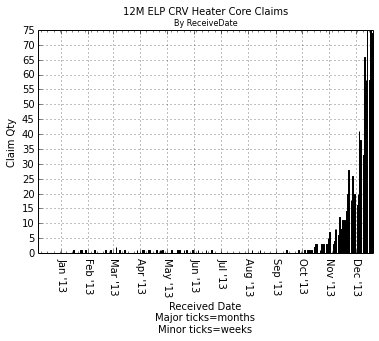

In [7]:
fig = plt.figure()
ax = plt.subplot(1,1,1)

# Let's define x-axis date interval sizes: month, week, or day
month_interval = 1   
months = MonthLocator(bymonth=range(1,13),  bymonthday=1, interval=month_interval)
month  = MonthLocator(bymonth=range(1,13),  bymonthday=1, interval=1)
week   = WeekdayLocator(byweekday=MO)  # Every MOnday
day    = DayLocator(bymonthday=range(1,32), interval=1)

# Let's define x-axis formatting intervals
monthsFmt = DateFormatter("%b '%y")
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(week)
ax.xaxis.grid(which='major')

# Let's define y-axis formatting
y_major_ticks = MultipleLocator(5)
ax.yaxis.set_major_locator(y_major_ticks)
ax.yaxis.grid(which='major')

#plt.title("\large{Plotting Dates}")
plt.bar(ts.index, ts.values)
plt.title("By ReceiveDate",fontsize=8)
plt.xticks(rotation=-90)
plt.xlabel("Received Date\nMajor ticks=months\nMinor ticks=weeks")
plt.ylabel("Claim Qty")
ax.text(.255,1.07, "12M ELP FOCUS Heater Core Claims", transform=ax.transAxes)
plt.show()

In [8]:
subset = ts["2013-10-01":]

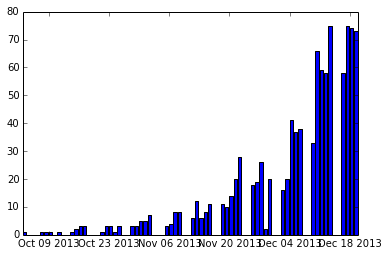

In [9]:
plt.bar(subset.index, subset.values)
plt.show()